# Peter och vargen: Introduktion till förstärkningsinlärning

I denna handledning kommer vi att lära oss hur man tillämpar förstärkningsinlärning på ett problem med att hitta vägar. Miljön är inspirerad av den musikaliska sagan [Peter och vargen](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) av den ryske kompositören [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Det är en berättelse om den unge pionjären Peter, som modigt lämnar sitt hus och går till skogsgläntan för att jaga vargen. Vi kommer att träna maskininlärningsalgoritmer som hjälper Peter att utforska området och skapa en optimal navigeringskarta.

Först, låt oss importera några användbara bibliotek:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Översikt av Förstärkningsinlärning

**Förstärkningsinlärning** (RL) är en inlärningsteknik som låter oss lära oss ett optimalt beteende hos en **agent** i en viss **miljö** genom att utföra många experiment. En agent i denna miljö bör ha ett **mål**, definierat av en **belöningsfunktion**.

## Miljön

För enkelhetens skull, låt oss anta att Peters värld är en kvadratisk spelbräda med storleken `width` x `height`. Varje ruta på denna bräda kan vara:
* **mark**, där Peter och andra varelser kan gå
* **vatten**, där man uppenbarligen inte kan gå
* **ett träd** eller **gräs** - en plats där man kan vila
* **ett äpple**, som representerar något Peter gärna vill hitta för att äta
* **en varg**, som är farlig och bör undvikas

För att arbeta med miljön kommer vi att definiera en klass som heter `Board`. För att undvika att överbelasta denna notebook med kod har vi flyttat all kod för att arbeta med brädan till en separat modul som heter `rlboard`, vilken vi nu kommer att importera. Du kan titta inuti denna modul för att få mer detaljer om implementeringens interna funktioner.


In [2]:
from rlboard import *

Låt oss nu skapa ett slumpmässigt bräde och se hur det ser ut:


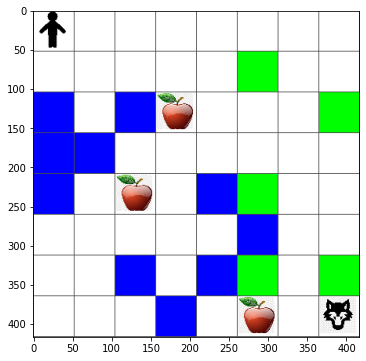

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Åtgärder och Policy

I vårt exempel är Peters mål att hitta ett äpple, samtidigt som han undviker vargen och andra hinder. För att göra detta kan han i princip gå runt tills han hittar ett äpple. Därför kan han vid varje position välja mellan en av följande åtgärder: upp, ner, vänster och höger. Vi kommer att definiera dessa åtgärder som en ordbok och koppla dem till par av motsvarande koordinatförändringar. Till exempel skulle att röra sig åt höger (`R`) motsvara paret `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategin för vår agent (Peter) definieras av en så kallad **policy**. Låt oss titta på den enklaste policyn som kallas **slumpmässig promenad**.

## Slumpmässig promenad

Låt oss först lösa vårt problem genom att implementera en strategi för slumpmässig promenad.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Låt oss köra slumpvandringsexperimentet flera gånger och se det genomsnittliga antalet steg som tas:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Belöningsfunktion

För att göra vår policy mer intelligent behöver vi förstå vilka drag som är "bättre" än andra.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Bygg en Q-Tabell, eller en flerdimensionell matris. Eftersom vår spelplan har dimensionerna `width` x `height`, kan vi representera Q-Tabellen med en numpy-matris med formen `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Skicka Q-tabellen till plotfunktionen för att visualisera tabellen på brädet:


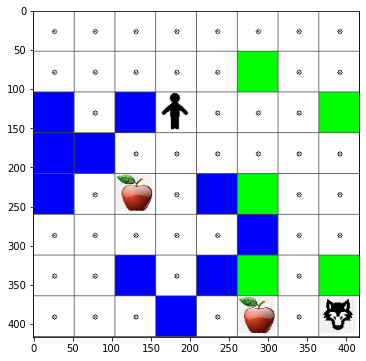

In [9]:
m.plot(Q)

## Essensen av Q-Learning: Bellman-ekvationen och inlärningsalgoritmen

Skriv en pseudokod för vår inlärningsalgoritm:

* Initiera Q-Tabell Q med lika värden för alla tillstånd och handlingar
* Sätt inlärningshastighet $\alpha\leftarrow 1$
* Upprepa simuleringen många gånger
   1. Börja på en slumpmässig position
   1. Upprepa
        1. Välj en handling $a$ vid tillstånd $s$
        2. Utför handlingen genom att flytta till ett nytt tillstånd $s'$
        3. Om vi stöter på ett slutspelsvillkor, eller den totala belöningen är för liten - avsluta simuleringen  
        4. Beräkna belöningen $r$ vid det nya tillståndet
        5. Uppdatera Q-Funktionen enligt Bellman-ekvationen: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Uppdatera total belöning och minska $\alpha$.

## Exploatera vs. Utforska

Det bästa tillvägagångssättet är att balansera mellan utforskning och exploatering. När vi lär oss mer om vår miljö, kommer vi vara mer benägna att följa den optimala vägen, men det är också viktigt att välja den outforskade vägen då och då.

## Python-implementation

Nu är vi redo att implementera inlärningsalgoritmen. Innan dess behöver vi också en funktion som kan konvertera godtyckliga värden i Q-Tabellen till en sannolikhetsvektor för motsvarande handlingar:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Vi lägger till en liten mängd `eps` till den ursprungliga vektorn för att undvika division med 0 i det initiala fallet, när alla komponenter i vektorn är identiska.

Den faktiska inlärningsalgoritmen kommer vi att köra i 5000 experiment, även kallade **epoker**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Efter att ha kört denna algoritm bör Q-Tabellen uppdateras med värden som definierar attraktiviteten hos olika åtgärder vid varje steg. Visualisera tabellen här:


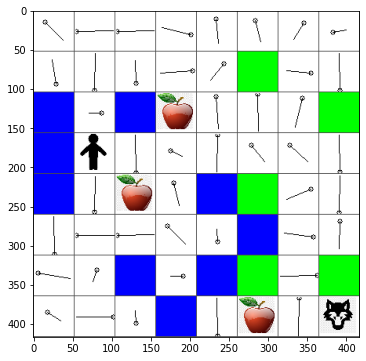

In [12]:
m.plot(Q)

## Kontrollera policyn

Eftersom Q-Tabellen listar "attraktiviteten" för varje handling i varje tillstånd, är det ganska enkelt att använda den för att definiera den effektiva navigeringen i vår värld. I det enklaste fallet kan vi helt enkelt välja den handling som motsvarar det högsta värdet i Q-Tabellen:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Om du testar koden ovan flera gånger, kanske du märker att den ibland bara "fastnar", och du måste trycka på STOP-knappen i notebooken för att avbryta den.

> **Uppgift 1:** Ändra `walk`-funktionen så att den begränsar den maximala längden på vägen till ett visst antal steg (till exempel 100), och observera hur koden ovan returnerar detta värde då och då.

> **Uppgift 2:** Ändra `walk`-funktionen så att den inte går tillbaka till platser där den redan har varit tidigare. Detta kommer att förhindra att `walk` hamnar i en loop, men agenten kan fortfarande bli "fast" på en plats där den inte kan ta sig vidare.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


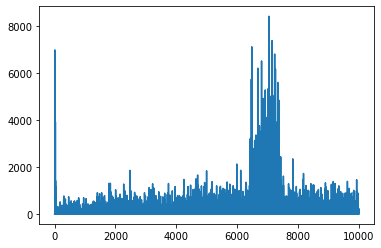

In [15]:
plt.plot(lpath)

Vad vi ser här är att den genomsnittliga längden på vägen först ökade. Detta beror troligen på att när vi inte vet något om miljön – är det troligt att vi fastnar i dåliga tillstånd, vatten eller varg. När vi lär oss mer och börjar använda denna kunskap kan vi utforska miljön längre, men vi vet fortfarande inte riktigt var äpplena finns.

När vi har lärt oss tillräckligt blir det lättare för agenten att nå målet, och vägens längd börjar minska. Dock är vi fortfarande öppna för utforskning, så vi avviker ofta från den bästa vägen och utforskar nya alternativ, vilket gör vägen längre än optimal.

Vad vi också observerar på denna graf är att längden vid något tillfälle ökade abrupt. Detta indikerar den stokastiska naturen hos processen, och att vi vid något tillfälle kan "förstöra" Q-Tabellens koefficienter genom att skriva över dem med nya värden. Detta bör idealt minimeras genom att minska inlärningshastigheten (dvs. mot slutet av träningen justerar vi endast Q-Tabellens värden med ett litet värde).

Överlag är det viktigt att komma ihåg att framgången och kvaliteten på inlärningsprocessen beror avsevärt på parametrar, såsom inlärningshastighet, minskning av inlärningshastighet och diskonteringsfaktor. Dessa kallas ofta **hyperparametrar**, för att skilja dem från **parametrar** som vi optimerar under träningen (t.ex. Q-Tabellens koefficienter). Processen att hitta de bästa värdena för hyperparametrar kallas **hyperparameteroptimering**, och det förtjänar ett eget ämne.


## Övning
#### En Mer Realistisk Värld för Peter och Vargen

I vår situation kunde Peter röra sig nästan utan att bli trött eller hungrig. I en mer realistisk värld måste han sätta sig ner och vila då och då, samt äta för att hålla sig vid liv. Låt oss göra vår värld mer realistisk genom att implementera följande regler:

1. När Peter rör sig från en plats till en annan förlorar han **energi** och blir mer **trött**.
2. Peter kan få mer energi genom att äta äpplen.
3. Peter kan bli av med trötthet genom att vila under trädet eller på gräset (dvs. gå till en plats på spelplanen med ett träd eller gräs - grönt fält).
4. Peter måste hitta och döda vargen.
5. För att kunna döda vargen behöver Peter ha vissa nivåer av energi och trötthet, annars förlorar han striden.

Modifiera belöningsfunktionen ovan enligt spelets regler, kör förstärkningsinlärningsalgoritmen för att lära dig den bästa strategin för att vinna spelet, och jämför resultaten av slumpmässiga rörelser med din algoritm i termer av antal vunna och förlorade spel.

> **Note**: Du kan behöva justera hyperparametrar för att få det att fungera, särskilt antalet epoker. Eftersom spelets framgång (att slåss mot vargen) är en sällsynt händelse, kan du förvänta dig mycket längre träningstid.



---

**Ansvarsfriskrivning**:  
Detta dokument har översatts med hjälp av AI-översättningstjänsten [Co-op Translator](https://github.com/Azure/co-op-translator). Även om vi strävar efter noggrannhet, bör du vara medveten om att automatiserade översättningar kan innehålla fel eller felaktigheter. Det ursprungliga dokumentet på dess ursprungliga språk bör betraktas som den auktoritativa källan. För kritisk information rekommenderas professionell mänsklig översättning. Vi ansvarar inte för eventuella missförstånd eller feltolkningar som uppstår vid användning av denna översättning.
